In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
%matplotlib inline
import matplotlib.pyplot as plt

In [52]:
fx_rates = pd.read_excel("./Data/FX_ALL_MONTHLY.xlsx", index_col=0)
fx_rates = fx_rates[fx_rates!=0].dropna()
fx_rates.index = pd.to_datetime(fx_rates.index)
fx_rates = fx_rates.sort_index()
equities = pd.read_excel("./Data/MSCI_ALL_LOCAL_MONTHLY.xlsx", index_col=0, sheet_name="Sheet1")
equities = equities.sort_index()
interestrates = pd.read_excel("./Data/3M_INTEREST_RATES_MONTHLY.xlsx", index_col=0).dropna()
interestrates.columns=pd.read_excel("./Data/3M_interest_rates.xlsx").columns
interestrates.index = pd.to_datetime(interestrates.index)
interestrates = interestrates.sort_index()

In [90]:
def excess_equity_returns(equity_returns, stfir):
    #stfir: short-term foreign interest rate (quoted per annum)
    
    # ensure index is sorted
    equity_returns = equity_returns.sort_index()
    stfir = stfir.sort_index()
    
    #ensure index matches
    equity_returns = equity_returns[equity_returns.index.isin(stfir.index)]
    stfir = stfir[stfir.index.isin(equity_returns.index)]
    
    return equity_returns - ((1+stfir)**(1/4)-1)

def excess_currency_returns(r_fx, fi, di):
    # r_fx: exchange rate returns, fi: foreign interest rate, di: domestic interest rate
    # calculate returns by using a 3 month shift
    # Appreciation in the rate means an increase in the value of domestic currency so returns are calculated on inverse
    r_fx = ((1/r_fx.iloc[3:,:].values)/(1/r_fx.iloc[:-3,:]) -1)
    # exclude domestic currency name from fx rate names
    r_fx.columns = [name.replace(di.name, "") for name in r_fx.columns]
    # sort the columns as in the interest rates df
    r_fx = r_fx[fi.columns]
    ans = r_fx + (fi.sub(di, axis="rows"))
    # adjust for domestic currency
    ans[di.name] = 0
    return ans

def sigma_fx_func(r_fx, fi, di):
    # get excess returns
    excess_r = excess_currency_returns(r_fx, fi, di)
    # return their variance-covariance matirx / pandas cov()
    return excess_r.cov()

def fx_hedge_weights():
    pass

def get_weights(alpha_eq, alpha_fx):
    # alpha_eq: expected excess returns for hedged equities, alpha_fx:  currency expected excess returns
    sigma_fx = alpha_fx.cov()
    sigma_fx_inv = np.linalg.pinv(sigma_fx)
    sigma_eqfx = pd.Series({cur:alpha_fx[cur].cov(alpha_eq[cur]) for cur in alpha_fx.columns})
    
    
    w_hedge = -np.matmul(sigma_fx_inv, sigma_eqfx)
    w_alpha = np.matmul(sigma_fx_inv,alpha_fx.mean())
    
    alpha_minvar = alpha_eq.mean() - np.matmul(alpha_fx.mean(), np.matmul(sigma_fx_inv, sigma_eqfx)) # done
    sigma_minvar = alpha_eq.std()**2 - np.matmul(sigma_eqfx.T, np.matmul(sigma_fx_inv, sigma_eqfx)) # done
   
    k_opt = (sigma_minvar**2)/alpha_minvar
    w_opt = w_hedge + np.matmul(k_opt, w_hedge)
    return w_opt
  

In [55]:
domestic_currency="CHF"
# Calculate Excess Equity returns
# Calculate returns for 3 month holing period in local currencies
eq_returns = equities.rolling(3).agg(lambda x: (x[-1]/x[0]-1))
# Calculate excess returns
alpha_eq = pd.DataFrame(columns=interestrates.columns, index = interestrates.index)
alpha_eq["CHF"] = excess_equity_returns(eq_returns["MXUS Index"], interestrates["CHF"])
alpha_eq["USD"] = excess_equity_returns(eq_returns["MSDLE15 Index"], interestrates["USD"][:-3])
alpha_eq["EUR"] = excess_equity_returns(eq_returns["MSDLUK Index"], interestrates["EUR"][:-3])
alpha_eq["CAD"] = excess_equity_returns(eq_returns["MSDLCA Index"], interestrates["CAD"][:-3])
alpha_eq["GBP"] = excess_equity_returns(eq_returns["MSDLE15 Index"], interestrates["GBP"][:-3])
alpha_eq["JPY"] = excess_equity_returns(eq_returns["MSDLJN Index"], interestrates["JPY"][:-3])
alpha_eq["AUD"] = excess_equity_returns(eq_returns["MSDLAS Index"], interestrates["AUD"][:-3])

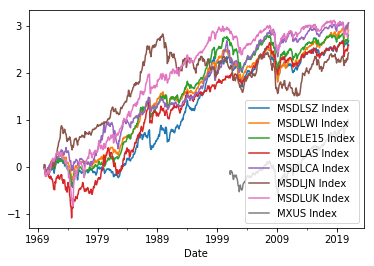

In [56]:
# Cumulative monthly log returns
np.log(1+(equities.pct_change())).cumsum().plot()

In [91]:
# Calculate Excess Currency returns
interestrates = interestrates[interestrates.index.isin(fx_rates.index)]
fx_rates = fx_rates[fx_rates.index.isin(interestrates.index)]
fi = interestrates[[cur for cur in interestrates.columns if cur != domestic_currency ]]
di = interestrates[domestic_currency]
alpha_fx = excess_currency_returns(fx_rates, fi, di)

In [99]:
sr_opti_w = get_weights(alpha_eq, alpha_fx)

In [100]:
sr_opti_w


AUD   -0.381628
CAD   -0.765530
CHF   -0.321125
EUR    0.211605
GBP   -0.256805
JPY   -0.066608
USD   -0.019264
dtype: float64

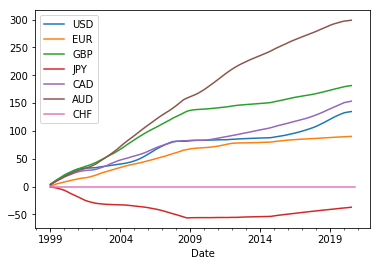

In [75]:
alpha_fx.iloc[::3].cumsum().plot()

In [134]:
monthly_weights = pd.DataFrame(columns=alpha_fx.columns, index=map(lambda x: (x.year, x.month), alpha_fx.index))
for year in set(alpha_eq.index.year):
    yearly_alpha_eq = alpha_eq[alpha_eq.index.year == year]
    yearly_alpha_fx = alpha_fx[alpha_fx.index.year == year]
    for month in set(alpha_eq.index.month):
        print(year,month,get_weights(yearly_alpha_eq[yearly_alpha_eq.index.month == month], alpha_fx[alpha_fx.index.month == month])
    

/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Deg

/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Deg

/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Deg

/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Deg

/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Deg

/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Deg

/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Deg

/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b)[0, 1]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/anaconda3/lib/python3.6/site-packages/pandas/core/nanops.py:805: RuntimeWarning: Deg

In [135]:
 monthly_weights.iloc[monthly_weights.index==(1999,2),:]= (1,1,1,1,1,1,1,1)

ValueError: could not broadcast input array from shape (8) into shape (1,7)